# Overview

This notebook focuses on classifying e-commerce product descriptions into predefined categories using Natural Language Processing (NLP) and Machine Learning. The project aims to automate product categorization, enhancing efficiency and accuracy on e-commerce platforms.

## Key Steps in the Project

1. **Data Exploration & Cleaning**: Inspecting and preprocessing the dataset, including handling missing values and normalizing category labels.
  
2. **Text Preprocessing**: Tokenizing, removing stopwords, and stemming words in product descriptions.
  
3. **Data Visualization**: Visualizing category distributions and generating word clouds to understand key terms in each category.
  
4. **Feature Extraction**: Using Word2Vec to convert textual data into numerical vectors.
  
5. **Model Training & Evaluation**: Training and evaluating various classifiers (e.g., Logistic Regression, Random Forest) to identify the best-performing model.

## Benefits and Key Techniques

- **Automated Categorization**: Reduces manual effort in classifying products.
- **Word2Vec Embedding**: Captures semantic meaning of text data.
- **Multiple Classifiers**: Provides a comparative analysis of different models.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from copy import deepcopy
import joblib as jb

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [34]:
# Data Source on Kaggle: https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification
df = pd.read_csv('/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv', names = ['category','description'], header = None)
df.head()

,category,description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [6]:
# Show shape 
df.shape

(50425, 2)

In [9]:
# Show dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     50425 non-null  object
 1   description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


# Exploratory data analysis

In [10]:
# check about none values
df.isnull().sum()

category       0
description    1
dtype: int64

In [13]:
# Find row of none value
df[df['description'].isna() == True]

,category,description
39330,Clothing & Accessories,NaN


In [35]:
# Drop row of none value
df.dropna(inplace = True)

# Chech about none values again
df.isnull().sum()

category       0
description    0
dtype: int64

In [54]:
# Rename values of clothing and accessories to not have any space
df.category.replace('Clothing & Accessories', 'Clothing_Accessories', inplace = True)
df.category.unique()

/tmp/ipykernel_33/4281193159.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.category.replace('Clothing & Accessories', 'Clothing_Accessories', inplace = True)


array(['Household', 'Books', 'Clothing_Accessories', 'Electronics'],
      dtype=object)

In [21]:
# Create word cloud object
wc = WordCloud(background_color = 'white', max_words = 50)

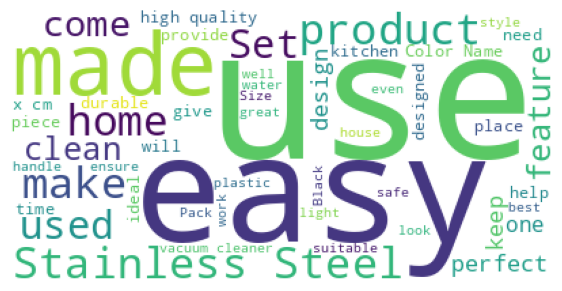

In [23]:
# Access samples of Household
household_df = df[df['category'] == 'Household'].description
household_text = ' '.join([row for row in household_df])

# Visualize word cloud for the data
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(household_text))
plt.axis('off')
plt.show()

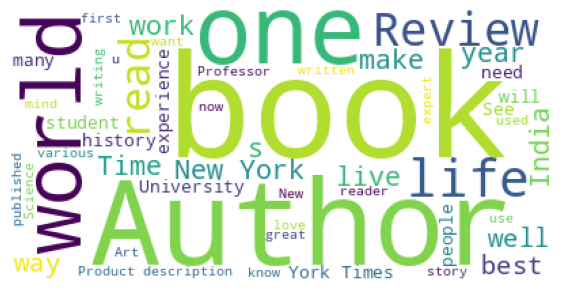

In [25]:
# Access samples of Books
books_df = df[df['category'] == 'Books'].description
books_text = ' '.join([row for row in books_df])

# Visualize word cloud for the data
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(books_text))
plt.axis('off')
plt.show()

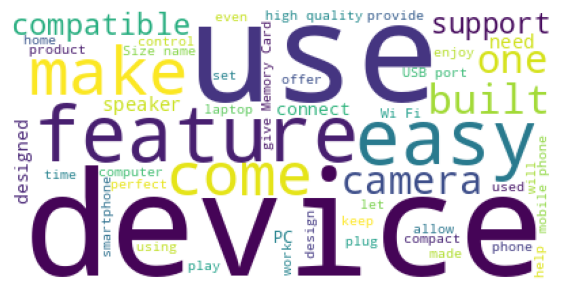

In [26]:
# Access samples of Books
Electronics_df = df[df['category'] == 'Electronics'].description
Electronics_text = ' '.join([row for row in Electronics_df])

# Visualize word cloud for the data
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(Electronics_text))
plt.axis('off')
plt.show()

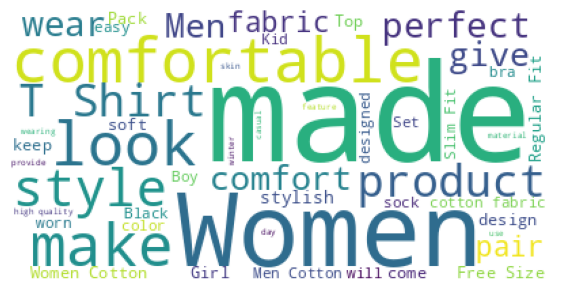

In [56]:
# Access samples of Books
Clothing_df = df[df['category'] == 'Clothing_Accessories'].description
Clothing_text = ' '.join([row for row in Clothing_df])

# Visualize word cloud for the data
plt.figure(figsize = (7,7))
plt.imshow(wc.generate(Clothing_text))
plt.axis('off')
plt.show()

category
Household               19313
Books                   11820
Electronics             10621
Clothing_Accessories     8670
Name: count, dtype: int64



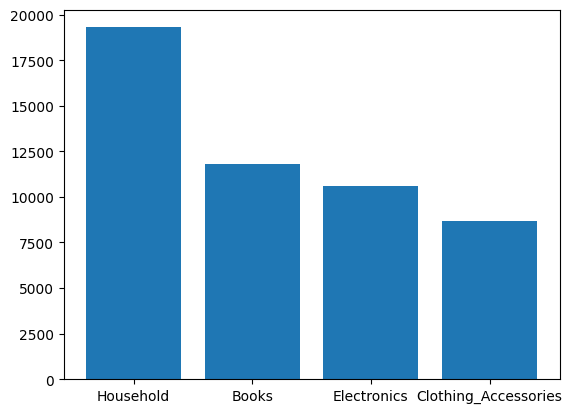

In [55]:
# Count values for each label and plot it
value_counts = df.category.value_counts()
print(value_counts, end = '\n\n')
plt.bar(value_counts.index, value_counts)
plt.show()

# Preporcess Data

In [57]:
# Sample 11820 rows from Household to handle inbalancing 
df_balanced = pd.concat([
    df[df['category'] != 'Household'],
    df[df['category'] == 'Household'].sample(n=11820, random_state=2024)
])
# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=2024).reset_index(drop=True)

In [58]:
# Show shape after handling inbalancing
df_balanced.shape

(42931, 2)

category
Household               19313
Books                   11820
Electronics             10621
Clothing_Accessories     8670
Name: count, dtype: int64



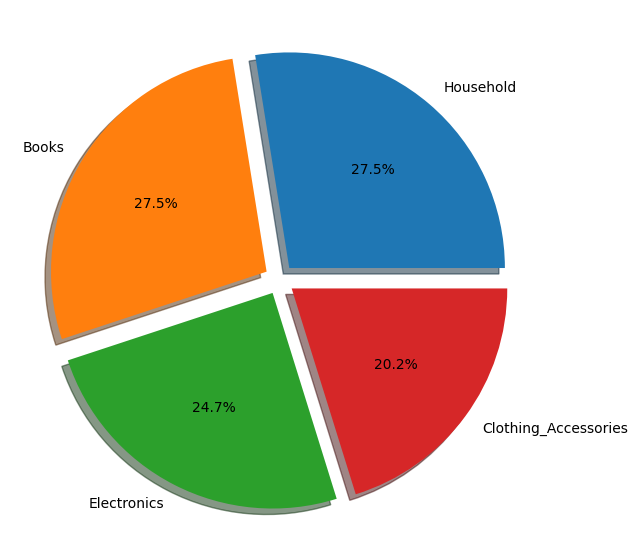

In [59]:
# Show and plot value counts for each label
balanced_counts = df_balanced.category.value_counts()
print(value_counts, end = '\n\n')

plt.figure(figsize = (7,7))
plt.pie(balanced_counts, labels = balanced_counts.index, explode = [0.07,0.07, 0.07, 0.07], shadow = True, autopct = '%1.1f%%')
plt.show()

## Label the categories

In [60]:
# Create number for each label to replace with it
labels_nums = {'Household':0,
               'Books':1,
               'Electronics':2,
               'Clothing_Accessories':3}
labels_nums

{'Household': 0, 'Books': 1, 'Electronics': 2, 'Clothing_Accessories': 3}

In [61]:
df_balanced.head()

,category,description
0,Household,Mandhania Classic Super Soft 350 GSM White Cot...
1,Electronics,Photron Tripod Stedy 450 with 4.5 Feet Pan Hea...
2,Books,"Geography(Assam, India & World) For Civil Serv..."
3,Books,Bank Interviews For IBPS (CWE) Successful Cand...
4,Electronics,Rewy Premium Quality Replacement Strap Accesso...


In [62]:
# Map the category labels to numbers
df_balanced['category_num'] = df_balanced['category'].apply(lambda x: labels_nums[x])

# Display the first few rows to verify
df_balanced.head()

,category,description,category_num
0,Household,Mandhania Classic Super Soft 350 GSM White Cot...,0
1,Electronics,Photron Tripod Stedy 450 with 4.5 Feet Pan Hea...,2
2,Books,"Geography(Assam, India & World) For Civil Serv...",1
3,Books,Bank Interviews For IBPS (CWE) Successful Cand...,1
4,Electronics,Rewy Premium Quality Replacement Strap Accesso...,2


## preprocess description column

In [79]:
# Load stop words
StopWords = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    text_cleaned = re.sub(r"[^\w\s\']+",'', text).lower()
    text_tokenized = word_tokenize(text_cleaned)
    result = []
    for word in text_tokenized:
        if word not in [string.punctuation, StopWords]:
            stemmed_word = stemmer.stem(word)
            result.append(stemmed_word)
    
    processed_result = ' '.join(result)
    return processed_result

In [81]:
# Preprocess description column
df_balanced['processed_desc'] = df_balanced['description'].apply(lambda row: preprocess(row))
df_balanced.head()

In [83]:
df_balanced['processed_desc']

0        mandhania classic super soft 350 gsm white cot...
1        photron tripod stedi 450 with 45 feet pan head...
2        geographyassam india world for civil servic ot...
3                bank interview for ibp cwe success candid
4        rewi premium qualiti replac strap accessori ba...
                               ...                        
42926    gandhi befor india about the author ramachandr...
42927    mhtcet triumph chemistri mcq base on std xi xi...
42928    awinn silicon protector case cover for mi 2000...
42929    docoss pemium classic glossi black steel 6 pin...
42930                             staad pro v8i for beginn
Name: processed_desc, Length: 42931, dtype: object

## Vectorize processed description column

In [85]:
# Train the Word2Vec model using the preprocessed description column
model_vectorizer = Word2Vec(
    sentences=df_balanced['processed_desc'],
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=0
)

In [86]:
def get_sentence_vector(sentence):
    vectors = [model_vectorizer.wv[word] for word in sentence if word in model_vectorizer.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model_vectorizer.vector_size)

In [87]:
# Preprocess description column
df_balanced['vectorized_desc'] = df_balanced['processed_desc'].apply(lambda row: get_sentence_vector(row))
df_balanced.head()

,category,description,category_num,processed_desc,vectorized_desc
0,Household,Mandhania Classic Super Soft 350 GSM White Cot...,0,mandhania classic super soft 350 gsm white cot...,"[-0.013540722, -0.04566581, 0.116702184, 0.062..."
1,Electronics,Photron Tripod Stedy 450 with 4.5 Feet Pan Hea...,2,photron tripod stedi 450 with 45 feet pan head...,"[-0.027603975, -0.037438974, 0.118618175, 0.06..."
2,Books,"Geography(Assam, India & World) For Civil Serv...",1,geographyassam india world for civil servic ot...,"[-0.013027764, 0.00144879, 0.12929346, 0.10396..."
3,Books,Bank Interviews For IBPS (CWE) Successful Cand...,1,bank interview for ibp cwe success candid,"[-0.020421542, -0.013340403, 0.105396524, 0.08..."
4,Electronics,Rewy Premium Quality Replacement Strap Accesso...,2,rewi premium qualiti replac strap accessori ba...,"[-0.018128913, -0.035247043, 0.12835097, 0.087..."


## Split data

In [88]:
X = df_balanced['vectorized_desc']
Y = df_balanced['category_num']
print(f'X shape {X.shape}')
print(f'Y shape {Y.shape}')

X shape (42931,)
Y shape (42931,)


In [111]:
# Convert X into 2D
X_stacked = np.stack(X.values)
print(f'New X shape: {X_stacked.shape}')

New X shape: (42931, 100)


In [115]:
# Split data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(X_stacked, Y , stratify = Y, train_size = 0.85, random_state = 2024)
print(f'x train size {x_train.shape}, x test shape {x_test.shape}')
print(f'y train size {y_train.shape}, y test shape {y_test.shape}')

x train size (36491, 100), x test shape (6440, 100)
y train size (36491,), y test shape (6440,)


In [121]:
# Check about number of values for each label
print(y_train.value_counts(), end = '\n\n')
print(y_test.value_counts())

category_num
0    10047
1    10047
2     9028
3     7369
Name: count, dtype: int64

category_num
1    1773
0    1773
2    1593
3    1301
Name: count, dtype: int64


# Modeling

In [95]:
# Function to perform the model functionalities
def fit_predict(classifier, x_train, y_train, x_test, y_test):
    
    # Make model fit data
    classifier.fit(x_train, y_train)
    
    # Get Score on train and test data
    train_score = classifier.score(x_train, y_train)
    test_score = classifier.score(x_test, y_test)
    print(f'train score is {train_score}, test score is {test_score}')
    
    # Make model predict on test data
    test_prediction = classifier.predict(x_test)
    # Get accuracy, confusion matrix and classification report
    accuracy = accuracy_score(y_test, test_prediction) 
    cf_matrix = confusion_matrix(y_test, test_prediction)
    cl_report = classification_report(y_test, test_prediction)
    
    # Plot confusion matrix
    plt.figure(figsize=(7,7))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Show accuracy and classification report
    print(f'accuracy: {accuracy}\nclassification report:\n{cl_report}', '\n\n')
    
    return classifier

In [125]:
# Put all required models that can fit this problem
models = {
    'LogisticRegression': LogisticRegression(),
    'LinearSVC': LinearSVC(),
    'XGBClassifier':XGBClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier()
}

LogisticRegression:



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train score is 0.6199884903126799, test score is 0.6268633540372671


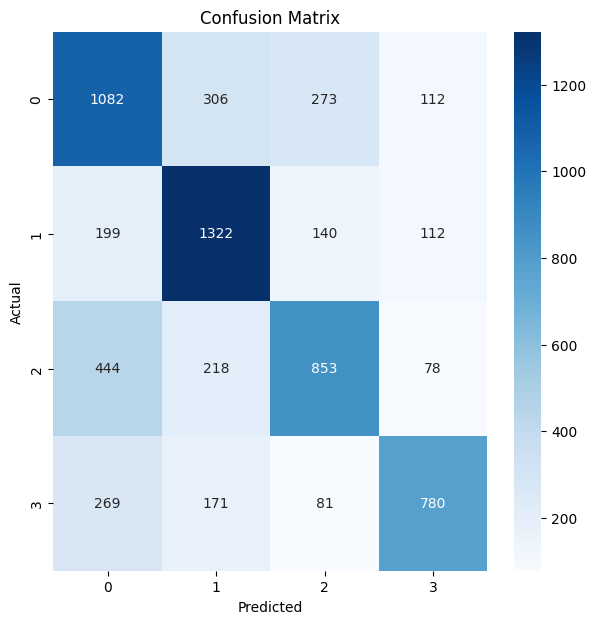

accuracy: 0.6268633540372671
classification report:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57      1773
           1       0.66      0.75      0.70      1773
           2       0.63      0.54      0.58      1593
           3       0.72      0.60      0.65      1301

    accuracy                           0.63      6440
   macro avg       0.64      0.62      0.63      6440
weighted avg       0.63      0.63      0.63      6440
 


LinearSVC:



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


train score is 0.6206735907484037, test score is 0.6282608695652174


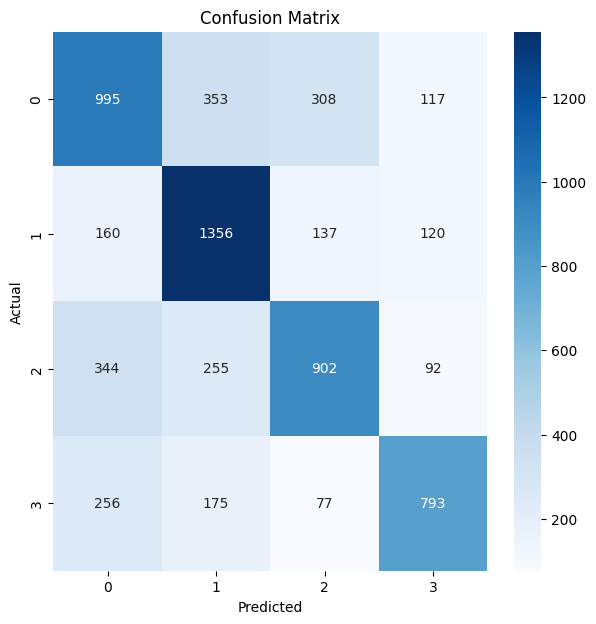

accuracy: 0.6282608695652174
classification report:
              precision    recall  f1-score   support

           0       0.57      0.56      0.56      1773
           1       0.63      0.76      0.69      1773
           2       0.63      0.57      0.60      1593
           3       0.71      0.61      0.65      1301

    accuracy                           0.63      6440
   macro avg       0.64      0.63      0.63      6440
weighted avg       0.63      0.63      0.63      6440
 


XGBClassifier:

train score is 0.9729522347976214, test score is 0.860248447204969


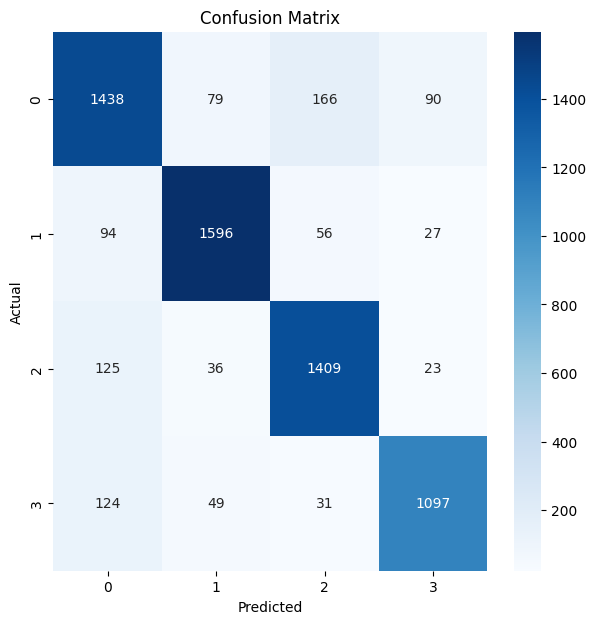

accuracy: 0.860248447204969
classification report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1773
           1       0.91      0.90      0.90      1773
           2       0.85      0.88      0.87      1593
           3       0.89      0.84      0.86      1301

    accuracy                           0.86      6440
   macro avg       0.86      0.86      0.86      6440
weighted avg       0.86      0.86      0.86      6440
 


DecisionTreeClassifier:

train score is 1.0, test score is 0.8003105590062112


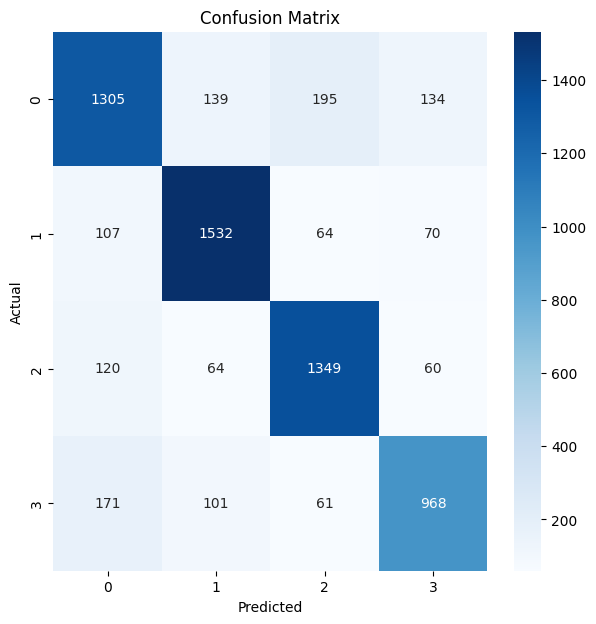

accuracy: 0.8003105590062112
classification report:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      1773
           1       0.83      0.86      0.85      1773
           2       0.81      0.85      0.83      1593
           3       0.79      0.74      0.76      1301

    accuracy                           0.80      6440
   macro avg       0.80      0.80      0.80      6440
weighted avg       0.80      0.80      0.80      6440
 


RandomForestClassifier:

train score is 1.0, test score is 0.8734472049689441


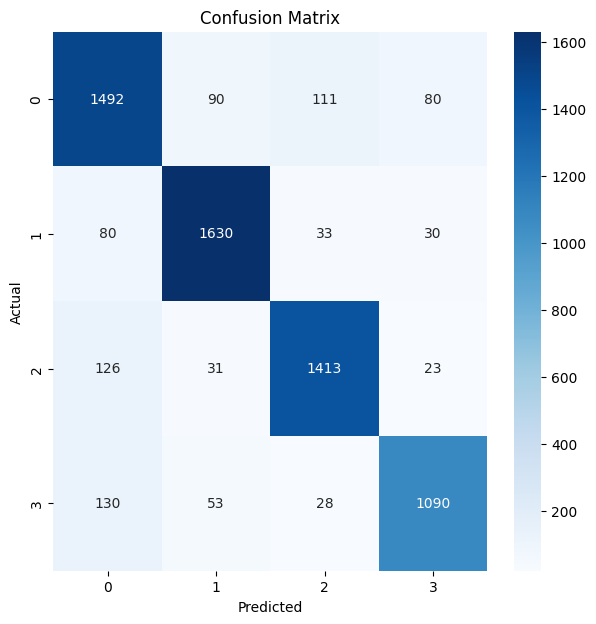

accuracy: 0.8734472049689441
classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1773
           1       0.90      0.92      0.91      1773
           2       0.89      0.89      0.89      1593
           3       0.89      0.84      0.86      1301

    accuracy                           0.87      6440
   macro avg       0.88      0.87      0.87      6440
weighted avg       0.87      0.87      0.87      6440
 


GradientBoostingClassifier:

train score is 0.727302622564468, test score is 0.7043478260869566


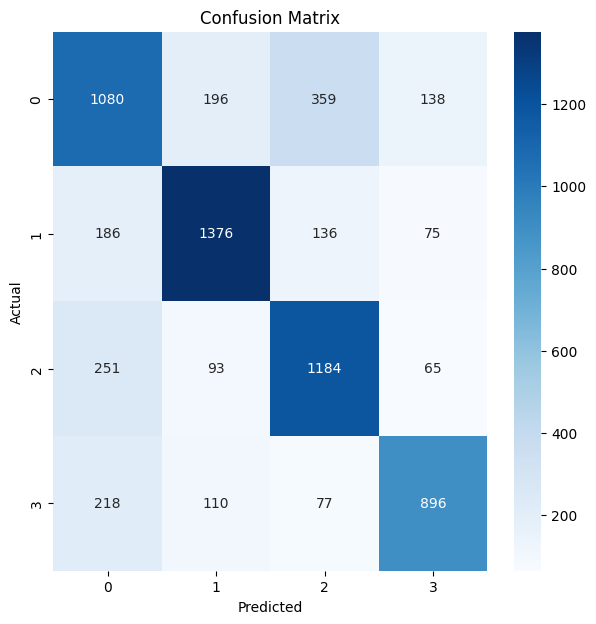

accuracy: 0.7043478260869566
classification report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.62      1773
           1       0.78      0.78      0.78      1773
           2       0.67      0.74      0.71      1593
           3       0.76      0.69      0.72      1301

    accuracy                           0.70      6440
   macro avg       0.71      0.70      0.71      6440
weighted avg       0.71      0.70      0.70      6440
 




In [126]:
trained_models = {}
for name, model in models.items():
    print(f'{name}:\n')
    model = fit_predict(model, x_train, y_train, x_test, y_test)
    trained_models[name] = deepcopy(model)

# Saving best model
Based on the previous results, the Random Forest Classifier model is the best one on the test data with accuracy 87%.

In [127]:
# Access Decision Tree Classifier
RandomForestClassifier = trained_models['RandomForestClassifier']

# Save the objects
jb.dump(RandomForestClassifier, 'PrepareModel\RandomForestClassifier.sav')
jb.dump(model_vectorizer, 'PrepareModel\\vectorizer.sav')

['vectorizer.sav']

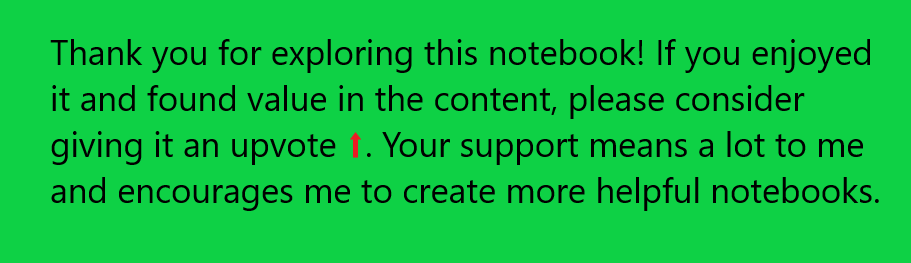